In [1]:
# Torch version
!python -c "import torch; print(torch.__version__)"

# Cuda version
!python -c "import torch; print(torch.version.cuda)"

2.6.0+cu124
12.4


In [2]:
# Uninstall
# !pip uninstall torch-scatter torch-sparse torch-cluster torch-spline-conv pyg-lib -y

In [3]:
# Update Torch
# !pip install torch==2.6.0 torchvision==0.21.0 torchaudio==2.6.0 --index-url https://download.pytorch.org/whl/cu124

In [4]:
# Install PyG (automatic)
# !pip install pyg_lib torch_scatter torch_sparse torch_cluster torch_spline_conv -f https://data.pyg.org/whl/torch-{torch.__version__}.html
# !pip install torch_geometric

In [5]:
# Verify instalation
import torch
import torch_geometric
import torch_scatter

print(torch.__version__)
print(torch.version.cuda)
print(torch.cuda.is_available())
print(torch_scatter.__version__)
print(torch_geometric.__version__)


/home/ealvarez/miniconda3/envs/graph_matching/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


2.6.0+cu124
12.4
True
2.1.2+pt26cu124
2.7.0


In [6]:
from model_PyG import *
from utils import *

In [7]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn.functional as F
import torch_geometric.transforms as T

from mpl_toolkits.mplot3d import Axes3D
from sklearn.decomposition import PCA
from sklearn.neighbors import NearestNeighbors
from sklearn.preprocessing import StandardScaler
from torch_geometric.data import InMemoryDataset, Data
from torch_geometric.transforms import Compose
from torch_geometric.utils import dense_to_sparse, negative_sampling
from torch.nn.functional import binary_cross_entropy_with_logits
from torch.optim import Adam

In [8]:
import torch_geometric
print(torch_geometric.__version__)

np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
torch.cuda.manual_seed_all(0)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

2.7.0


### Utils

In [9]:
def info(data):
	print("Validate:\t {}".format(data.validate(raise_on_error=True)))
	print("Num. nodes:\t {}".format(data.num_nodes))
	print("Num. edges:\t {}".format(data.num_edges))
	print("Num. features:\t {}".format(data.num_node_features))
	print("Has isolated:\t {}".format(data.has_isolated_nodes()))
	print("Has loops:\t {}".format(data.has_self_loops()))
	print("Is directed:\t {}".format(data.is_directed()))
	print("Is undirected:\t {}".format(data.is_undirected()))
	print("{}".format(data.edge_index))
	print("{}".format(data.x))
	print("{}".format(data.edge_attr))

def compute_num_neg_samples(edge_index, num_nodes, ratio):
	E = edge_index.size(1)
	max_neg = num_nodes * num_nodes - E
	return min(int(ratio * E), max_neg)

def neg_ratio_schedule(epoch, max_epoch):
	start = 5.0
	end = 1.0
	return start - (start - end) * (epoch / max_epoch)

class EarlyStopping:
	def __init__(self, patience=5, delta=0, warmup=5, verbose=False):
		self.patience = patience
		self.delta = delta
		self.warmup = warmup
		self.verbose = verbose
		self.best_loss = None
		self.no_improvement_count = 0
		self.stop_training = False
	
	def check_early_stop(self, loss, epoch):
		if epoch >= self.warmup:
			if self.best_loss is None or loss < self.best_loss - self.delta:
				self.best_loss = loss
				self.no_improvement_count = 0
			else:
				self.no_improvement_count += 1
				if self.no_improvement_count >= self.patience:
					self.stop_training = True
					if self.verbose:
						print("Stopping early as no improvement has been observed.")

### Setup

In [10]:
dataset = "deybis_filter_september_05" # "deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05", "Douban Online_Offline", "ACM_DBLP" # args.dataset
encoder = "GIN" # Change GIN, GINE
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
# device = torch.device("cpu")

if (dataset == "ACM_DBLP"):
	train_set = ["ACM", "DBLP"]
	b = np.load("data/ACM-DBLP.npz")
	# train_features["ACM"] = [torch.from_numpy(b["x1"]).float()]
	# train_features["DBLP"] = [torch.from_numpy(b["x2"]).float()]
	test_pairs = b["test_pairs"].astype(np.int32)
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	# input_dim = 17
	output_feature_size = 128
	lr = 1e-4 # 1e-4
	epochs = 100
elif (dataset == "Douban Online_Offline"):
	train_set = ["Online", "Offline"]
	a1, f1, a2, f2, test_pairs = load_douban()
	# f1 = f1.A
	# f2 = f2.A
	test_pairs = torch.tensor(np.array(test_pairs, dtype=int)) - 1
	test_pairs = test_pairs.numpy()
	# train_features["Online"] = [torch.from_numpy(f1).float()]
	# train_features["Offline"] = [torch.from_numpy(f2).float()]
	NUM_HIDDEN_LAYERS = 6
	HIDDEN_DIM = [512, 512, 512, 512, 512, 512, 512]
	# input_dim = 538
	output_feature_size = 512
	lr = 0.0001
	epochs = 100
elif (dataset == "mentos_05"):
	train_set = [
		# "Orange_1", "Orange_2",
		"Red_1", "Red_2",
		# "Yellow_1", "Yellow_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100
elif (dataset in ["deybis_filter_september_05", "deybis_05", "vanessa_05"]):
	train_set = [
		"FrescoAmazonas_1", "FrescoAmazonas_2",
		# "FrescoCusco_1", "FrescoCusco_2",
		# "FrescoSanMartin_1", "FrescoSanMartin_2",
		# "SecoAmazonas_1", "SecoAmazonas_2",
		# "SecoCusco_1", "SecoCusco_2",
		# "SecoSanMartin_1", "SecoSanMartin_2"
	]
	NUM_HIDDEN_LAYERS = 12
	HIDDEN_DIM = [1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024,1024]
	output_feature_size = 128
	lr = 0.0001
	epochs = 100

### Understand Data (PyG)

#### Data (PyG)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([[0, 1], [1, 2], [2, 3], [3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3]], dtype=torch.long)
x = torch.tensor([
	[0, 1],
	[1, 2],
	[2, 3],
	[3, 4]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 1.0, 1.5], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_weight=edge_weight)

info(data)
transform = Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
])

data = transform(data)

info(data)

In [ ]:
edge_index = torch.tensor([
	[0, 1],
	[1, 0],
	[1, 2],
	[2, 1]], dtype=torch.long)
x = torch.tensor([
	[0, 1], 
	[1, 2], 
	[2, 3]], dtype=torch.float)
edge_weight = torch.tensor([0.5, 0.5, 1.0, 1.0], dtype=torch.float)
edge_attr = torch.tensor([
	[0.5, 1.0], 
	[0.5, 1.0], 
	[1.0, 1.5], 
	[1.0, 1.5]], dtype=torch.float)

data = Data(x=x, edge_index=edge_index.t().contiguous(), edge_attr=edge_attr)

print(data)
info(data)

transform = T.Compose([
	T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

data = transform(data)
print(data)
info(data)

#### Data ACM_DBLP

In [ ]:
train_set

In [ ]:
b.files

In [ ]:
edge_index1 = b["edge_index1"]
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2 = b["edge_index2"]
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = b["x1"]
print(x1.shape)
x1

In [ ]:
x2 = b["x2"]
print(x2.shape)
x2

In [ ]:
test_pairs

#### Data Douban Online_Offline

In [ ]:
train_set

In [ ]:
a1, f1, a2, f2, test_pairs = load_douban()

In [ ]:
torch.from_numpy(a1.toarray())

In [ ]:
torch.from_numpy(a2.toarray())

In [ ]:
torch.from_numpy(f1.toarray())

In [ ]:
torch.from_numpy(f2.toarray())

In [ ]:
edge_index1, edge_attr1 = dense_to_sparse(torch.from_numpy(a1.toarray()))
print(edge_index1.shape)
edge_index1

In [ ]:
edge_index2, edge_attr2 = dense_to_sparse(torch.from_numpy(a2.toarray()))
print(edge_index2.shape)
edge_index2

In [ ]:
x1 = torch.from_numpy(f1.toarray()).float()
print(x1.shape)
x1

In [ ]:
x2 = torch.from_numpy(f2.toarray()).float()
print(x2.shape)
x2

In [ ]:
test_pairs

### Create Data (PyG)

In [11]:
# Only for GIN
""" transform = Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(fill_value=1.0),
	T.ToDevice(device)
]) """

# For GIN and GINE
transform = T.Compose([
	# T.NormalizeFeatures(),
	T.ToUndirected(reduce="mean"),
	T.AddSelfLoops(attr="edge_attr", fill_value="mean"),
	T.ToDevice(device)
])

In [12]:
print("Loading training datasets")

train_loader = {}
# scaler = StandardScaler()

if dataset == "ACM_DBLP":
	for i, ts in enumerate(train_set):
		edge_index = torch.tensor(b[f"edge_index{i+1}"], dtype=torch.long)
		x = torch.tensor(b[f"x{i+1}"], dtype=torch.float)
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling
		
		""" if i==1:
			x = x[torch.randperm(x.size(0))] # permutations for test """

		edge_attr = torch.ones((edge_index.size(1), 1)) # Only for test GINE

		data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
		info(data)

		data = transform(data)
		train_loader[ts] = data
		info(data)
elif dataset == "Douban Online_Offline":
	edge_index1, _= dense_to_sparse(torch.from_numpy(a1.toarray()))
	x1 = torch.from_numpy(f1.toarray()).float()
	data1 = Data(x=x1, edge_index=edge_index1)
	data1 = transform(data1)
	train_loader[train_set[0]] = data1
	info(data1)

	edge_index2, _= dense_to_sparse(torch.from_numpy(a2.toarray()))
	x2 = torch.from_numpy(f2.toarray()).float()
	data2 = Data(x=x2, edge_index=edge_index2)
	data2 = transform(data2)
	train_loader[train_set[1]] = data2
	info(data2)
elif dataset in ["deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05"]: # Change
	features = [0, 1, 2, 4, 5]

	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/input/nodes_{}.csv".format(dataset, ts))
		# idx, id, mz, rt, 0, 1, 2, ...

		df_intensity = df_nodes.iloc[:, 4:]
		# 0, 1, 2, ...

		df_edges = pd.read_csv("data/{}/input/edges_{}.csv".format(dataset, ts))
		# source, target, weight, subgroup

		# Node features
		""" mz = np.log10(df_nodes["mz"].values + 1e-8) # Log-transform m/z to stabilize scale differences
		rt = df_nodes["rt"].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8) # Z-score normalization for retention time (RT)

		intensity = df_intensity.values.astype(np.float32)
		intensity = intensity / (intensity.sum(axis=0, keepdims=True) + 1e-8)
		intensity_mean = intensity.mean(axis=1)

		intensity_std = intensity.std(axis=1)
		intensity_cv = intensity_std / (intensity_mean + 1e-8)
		intensity_cv = np.log1p(np.clip(intensity_cv, 0, 2.0))

		presence_ratio = (df_intensity > 0).mean(axis=1) # Acts as a reliability / confidence signal """

		# df_intensity = np.sign(df_intensity) * np.log10(np.abs(df_intensity) + 1e-8)

		mz = np.log10(df_nodes.iloc[:, 2].values + 1e-8)
		rt = df_nodes.iloc[:, 3].values
		rt = (rt - rt.mean()) / (rt.std() + 1e-8)
		intensity_mean = df_intensity.mean(axis=1).values
		intensity_std = df_intensity.std(axis=1).values
		intensity_cv = intensity_std / (intensity_mean + 1e-8)
		presence_ratio = (df_intensity > 0).mean(axis=1) # Import to check

		x = np.stack([
				mz,             			# 0 physicochemical identity
				rt,							# 1 chromatographic alignment
				np.log10(intensity_mean + 1e-8), 	# 2 global abundance
				intensity_std,  			# 3
				intensity_cv,   			# 4 robustness (anti-oversmoothing)
				presence_ratio  			# 5 reliability
			], axis=1)

		x = torch.tensor(x[:, features], dtype=torch.float) # [N, F]
		# x = torch.tensor(scaler.fit_transform(x.numpy())) # scaling

		# Edge index
		edge_index = torch.tensor(df_edges.iloc[:, [0, 1]].values.T, dtype=torch.long) # [2, E]

		# Edge attribute
		edge_weight = torch.tensor(df_edges.iloc[:, 2].values, dtype=torch.float) # [E]

		# edge_attr = edge_weight.view(-1, 1) # [E,1]
		edge_attr = torch.stack([
							edge_weight.abs(),        # strength
							torch.sign(edge_weight),  # direction (+1, -1)
							edge_weight ** 2          # nonlinearity
						], dim=1) # [E, 3]

		# Reduce number of edges
		""" mask = torch.abs(edge_weight) > 0.95
		edge_index = edge_index[:, mask]
		edge_attr  = edge_attr[mask] """

		data = Data(x=x, edge_index=edge_index.contiguous(), edge_attr=edge_attr)

		data = transform(data)
		# data = data.to(device)

		train_loader[ts] = data
		info(data)

		test_pairs = None # No use

Loading training datasets
Validate:	 True
Num. nodes:	 162
Num. edges:	 20648
Num. features:	 5
Has isolated:	 False
Has loops:	 True
Is directed:	 False
Is undirected:	 True
tensor([[  0,   0,   0,  ..., 159, 160, 161],
        [  1,   2,   3,  ..., 159, 160, 161]], device='cuda:1')
tensor([[ 2.2228, -1.4650,  7.1440,  1.0934,  1.0000],
        [ 2.1820, -1.3916,  6.5741,  0.5514,  1.0000],
        [ 2.4116, -1.3906,  6.8992,  0.7568,  1.0000],
        [ 2.3180, -1.3900,  7.2470,  0.7452,  1.0000],
        [ 2.3384, -1.3890,  7.1698,  0.3086,  1.0000],
        [ 2.1820, -1.3645,  6.4637,  0.6490,  1.0000],
        [ 2.1820, -1.3627,  6.7031,  0.0680,  1.0000],
        [ 2.2555, -1.3559,  6.5245,  0.5284,  1.0000],
        [ 2.1819, -1.3495,  6.1559,  0.6592,  1.0000],
        [ 2.2603, -1.3481,  6.2472,  0.4325,  1.0000],
        [ 2.1338, -1.3479,  6.2134,  0.3916,  1.0000],
        [ 2.2881, -1.3451,  6.3508,  0.5845,  1.0000],
        [ 2.3930, -1.3447,  5.7255,  0.9457,  1.0000],


In [13]:
train_loader

{'FrescoAmazonas_1': Data(x=[162, 5], edge_index=[2, 20648], edge_attr=[20648, 3]),
 'FrescoAmazonas_2': Data(x=[162, 5], edge_index=[2, 18464], edge_attr=[18464, 3])}

### Train

In [14]:
def fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs=None):
	best_hitAtOne = 0
	best_hitAtFive = 0
	best_hitAtTen = 0
	best_hitAtFifty = 0
	list_loss = []

	optimizer = Adam(model.parameters(), lr=lr,weight_decay=5e-4)
	
	# Initialize early stopping
	patience = 10
	delta = 1e-4 # 1e-4
	warmup = 10
	early_stopping = EarlyStopping(patience=patience, delta=delta, warmup=warmup, verbose=True)

	loop_obj = tqdm(range(1, epochs + 1))
	for epoch in loop_obj:
		loop_obj.set_description(f"Epoch: {epoch}")
		
		# Train
		model.train()
		loss = 0.0
		
		for ts in random.sample(train_set, k=len(train_set)): # shuffle train_set
			data = train_loader[ts]

			# Encoder
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
				# z = F.normalize(z, dim=1)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)

			# Positive edges
			pos_edge_index = data.edge_index
			
			# Negative edges
			# option 1
			neg_edge_index = negative_sampling(
				edge_index=data.edge_index,
				num_nodes=z.size(0),
				num_neg_samples=pos_edge_index.size(1), # Change 2 to other value if needed
				method="sparse"
			)

			# option 2 Negative edges (dynamic)
			""" ratio = neg_ratio_schedule(epoch, epochs)
			num_neg = compute_num_neg_samples(
				edge_index=edge_index,
				num_nodes=z.size(0),
				ratio=ratio
			)
			neg_edge_index = negative_sampling(
				edge_index=edge_index,
				num_nodes=z.size(0),
				num_neg_samples=num_neg,
				method="sparse"
			) """
			
			# Decoder
			# option 1
			pos_logits = (z[pos_edge_index[0]] * z[pos_edge_index[1]]).sum(dim=1)
			neg_logits = (z[neg_edge_index[0]] * z[neg_edge_index[1]]).sum(dim=1)
			
			# option 2
			""" pos_logits = F.cosine_similarity(
				z[pos_edge_index[0]],
				z[pos_edge_index[1]],
				dim=1
			)
			neg_logits = F.cosine_similarity(
				z[neg_edge_index[0]],
				z[neg_edge_index[1]],
				dim=1
			) """

			# Loss
			pos_labels = torch.ones_like(pos_logits)
			neg_labels = torch.zeros_like(neg_logits)

			# option 1
			""" loss_pos = binary_cross_entropy_with_logits(pos_logits, pos_labels)
			loss_neg = binary_cross_entropy_with_logits(neg_logits, neg_labels)
			loss += loss_pos + loss_neg """

			# option 2
			# num_pos = pos_edge_index.size(1)
			# num_neg = neg_edge_index.size(1)
			# pos_weight = torch.tensor([num_neg / num_pos], device=device)
			logits = torch.cat([pos_logits, neg_logits], dim=0)
			labels = torch.cat([pos_labels, neg_labels], dim=0)
			loss_temp = F.binary_cross_entropy_with_logits(logits, labels) #, pos_weight=pos_weight) # with pos_weight
			loss += loss_temp
			
		optimizer.zero_grad()
		loss = loss / no_samples
		loss.backward()
		optimizer.step()

		loop_obj.set_postfix_str(f"Loss: {loss.item():.4f}")
		list_loss.append(loss.item())

		# Check early stopping condition
		early_stopping.check_early_stop(loss.item(), epoch)
		if early_stopping.stop_training:
			print(f"Early stopping at epoch {epoch}")
			break

		# Evaluation (for firts dataset)
		""" model.eval()
		with torch.no_grad():
			keys = list(train_loader.keys())
			data1 = train_loader[keys[0]]
			data2 = train_loader[keys[1]]

			z1 = model(data1.x, data1.edge_index).detach()
			z2 = model(data2.x, data2.edge_index).detach()
			
			# Similarity matrix
			# option 1
			D = torch.cdist(z1, z2, 2)

			# option 2 (GPU problem)
			# D = 1 - F.cosine_similarity(z1.unsqueeze(1), z2.unsqueeze(0), dim=-1)

			# option 3 (Decoder cosine similarity)
			" "" z1n = F.normalize(z1, dim=1)
			z2n = F.normalize(z2, dim=1)
			D = 1 - (z1n @ z2n.T) " ""

			if dataset == "ACM_DBLP":
				test_idx = test_pairs[:, 0].astype(int)
				labels = test_pairs[:, 1].astype(int)
			else:
				test_idx = test_pairs[0, :].astype(int)
				labels = test_pairs[1, :].astype(int)
				
			hitAtOne = 0
			hitAtFive = 0
			hitAtTen = 0
			hitAtFifty = 0
			hitAtHundred = 0
			for i in range(len(test_idx)):
				dist_list = D[test_idx[i]]
				sorted_neighbors = torch.argsort(dist_list).cpu()
				label = labels[i]
				for j in range(100):
					if (sorted_neighbors[j].item() == label):
						if (j == 0):
							hitAtOne += 1
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 4):
							hitAtFive += 1
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 9):
							hitAtTen += 1
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 49):
							hitAtFifty += 1
							hitAtHundred += 1
							break
						elif (j <= 100):
							hitAtHundred += 1
							break
			cur_hitAtOne = hitAtOne / len(test_idx)
			cur_hitAtFive = hitAtFive / len(test_idx)
			cur_hitAtTen = hitAtTen / len(test_idx)
			cur_hitAtFifty = hitAtFifty / len(test_idx)

			if(cur_hitAtOne > best_hitAtOne): best_hitAtOne = cur_hitAtOne
			if (cur_hitAtFive > best_hitAtFive): best_hitAtFive = cur_hitAtFive
			if (cur_hitAtTen > best_hitAtTen): best_hitAtTen = cur_hitAtTen
			if (cur_hitAtFifty > best_hitAtFifty): best_hitAtFifty = cur_hitAtFifty

	print("The best results achieved:")
	print("Hit@1: ", end="")
	print(best_hitAtOne)
	print("Hit@5: ", end="")
	print(best_hitAtFive)
	print("Hit@10: ", end="")
	print(best_hitAtTen)
	print("Hit@50: ", end="")
	print(best_hitAtFifty) """

	# Evaluation (for others dataset)
	dict_node_embeddings = {}
	model.eval()
	with torch.no_grad():
		for ts in train_set:
			data = train_loader[ts]
			if encoder == "GIN":
				z = model(data.x, data.edge_index)
			elif encoder == "GINE":
				z = model(data.x, data.edge_index, data.edge_attr)
			dict_node_embeddings[ts] = z.cpu().numpy()

	del loss, z
	# torch.cuda.synchronize()
	torch.cuda.empty_cache()
	
	return dict_node_embeddings, list_loss

In [15]:
train_set

['FrescoAmazonas_1', 'FrescoAmazonas_2']

In [16]:
no_samples = len(train_set) # * (1 + 1)  # num datasets * num of samples by dataset 
input_dim = train_loader[train_set[0]].num_node_features

if encoder == "GIN":
	model = TGAE_GIN(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size).to(device)
elif encoder == "GINE":
	edge_dim = train_loader[train_set[0]].edge_attr.size(1)

	model = TGAE_GINE(NUM_HIDDEN_LAYERS,
				input_dim,
				HIDDEN_DIM,
				output_feature_size, edge_dim).to(device)

print("Generating training features")
print("Fitting model")
print(encoder, dataset, lr, epochs, input_dim, output_feature_size, no_samples)

dict_node_embeddings, list_loss = fit_TGAE_subgraph(encoder, dataset, no_samples, model, epochs, train_loader, lr, test_pairs)

Generating training features
Fitting model
GIN deybis_filter_september_05 0.0001 100 5 128 2


Epoch: 77:  76%|███████▌  | 76/100 [00:04<00:01, 15.42it/s, Loss: 0.5622]


Stopping early as no improvement has been observed.
Early stopping at epoch 77


### Get embeddings

In [17]:
dict_node_embeddings

{'FrescoAmazonas_1': array([[ 0.11597876,  0.05756678, -0.03628939, ...,  0.00369425,
         -0.02979345,  0.10162163],
        [ 0.14179246,  0.0638968 , -0.06465357, ..., -0.00175011,
         -0.03799227,  0.1940465 ],
        [ 0.13625856,  0.06275326, -0.05044097, ..., -0.0098717 ,
         -0.04135931,  0.1466409 ],
        ...,
        [ 0.09427653,  0.0331639 , -0.01962735, ..., -0.00917689,
         -0.01084114,  0.02620211],
        [ 0.09301313,  0.03043685, -0.02283271, ..., -0.00513065,
          0.00257548,  0.03388867],
        [ 0.09192182,  0.03220307, -0.02939213, ...,  0.00266746,
          0.02152297,  0.06836436]], dtype=float32),
 'FrescoAmazonas_2': array([[ 0.12594491,  0.05083743, -0.04786161, ..., -0.00316805,
         -0.05152003,  0.10882876],
        [ 0.13936532,  0.06442914, -0.05234167, ..., -0.00983172,
         -0.04026285,  0.15721758],
        [ 0.13049656,  0.05202295, -0.04882933, ..., -0.00739125,
         -0.05237176,  0.11278106],
        ...,

### Plot

In [18]:
# Concatenate embeddings

node_embeddings_cat = np.concatenate(list(dict_node_embeddings.values()), axis=0)
print(node_embeddings_cat.shape)
node_embeddings_cat

(324, 128)


array([[ 0.11597876,  0.05756678, -0.03628939, ...,  0.00369425,
        -0.02979345,  0.10162163],
       [ 0.14179246,  0.0638968 , -0.06465357, ..., -0.00175011,
        -0.03799227,  0.1940465 ],
       [ 0.13625856,  0.06275326, -0.05044097, ..., -0.0098717 ,
        -0.04135931,  0.1466409 ],
       ...,
       [ 0.07810967,  0.051005  , -0.02142496, ...,  0.02670514,
         0.13879587,  0.13882568],
       [ 0.044084  ,  0.00926785, -0.01189782, ...,  0.04075172,
         0.10914255,  0.00680172],
       [ 0.05887469,  0.00038851, -0.01708096, ...,  0.01590607,
         0.07739529, -0.01718663]], dtype=float32)

In [19]:
# Get labels

labels = []
for i, node_embeddings in enumerate(list(dict_node_embeddings.values())):
	labels += [i] * node_embeddings.shape[0]
print(len(labels))
print(labels)

324
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [20]:
list_loss

[4.539868354797363,
 4.384865760803223,
 1.4102118015289307,
 0.9689785242080688,
 0.9081020951271057,
 0.74872225522995,
 0.6290212869644165,
 0.5968879461288452,
 0.599050760269165,
 0.5922439694404602,
 0.5816610455513,
 0.574286699295044,
 0.5707522630691528,
 0.5714325904846191,
 0.5739293098449707,
 0.5756301879882812,
 0.5753360986709595,
 0.5734184980392456,
 0.5708394050598145,
 0.5682226419448853,
 0.5655689835548401,
 0.5633796453475952,
 0.5619383454322815,
 0.5610404014587402,
 0.5602775812149048,
 0.5598127841949463,
 0.5595681667327881,
 0.559370219707489,
 0.5591758489608765,
 0.5590165853500366,
 0.5588928461074829,
 0.558718204498291,
 0.5585323572158813,
 0.5583255290985107,
 0.5581009387969971,
 0.5578337907791138,
 0.5575528144836426,
 0.5572522282600403,
 0.5569460391998291,
 0.5566239953041077,
 0.5563048124313354,
 0.5559859275817871,
 0.5556620359420776,
 0.5553396940231323,
 0.555017352104187,
 0.5546820759773254,
 0.5543539524078369,
 0.5540266036987305,
 0.5

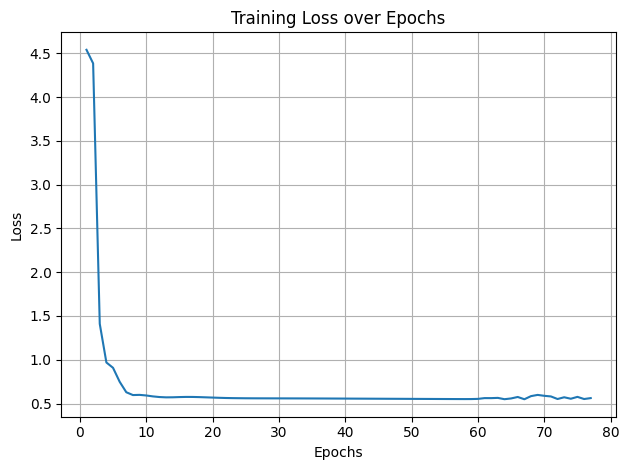

In [21]:
# Loss

plt.figure()
plt.plot(range(1, len(list_loss) + 1), list_loss) #, marker=".")
# plt.plot(range(1, len(list_loss) + 1), np.log(list_loss)) #, marker=".")
plt.title("Training Loss over Epochs")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid()
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/loss_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

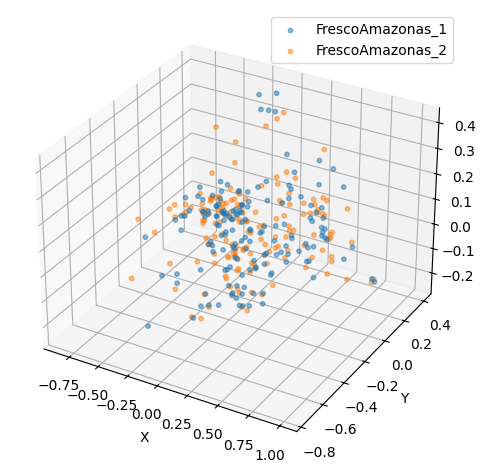

In [22]:
# Node embeddings 3D

if node_embeddings_cat.shape[1] > 3:
	pca = PCA(n_components=3)
	node_embeddings_cat_3d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_3d = node_embeddings_cat.copy()

fig = plt.figure()
ax = fig.add_subplot(projection="3d")

for c in np.unique(labels):
	ax.scatter(
		node_embeddings_cat_3d[:, 0][labels == c],
		node_embeddings_cat_3d[:, 1][labels == c], 
		node_embeddings_cat_3d[:, 2][labels == c],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.set_zlabel("Z")
ax.legend()
plt.tight_layout()
plt.show()

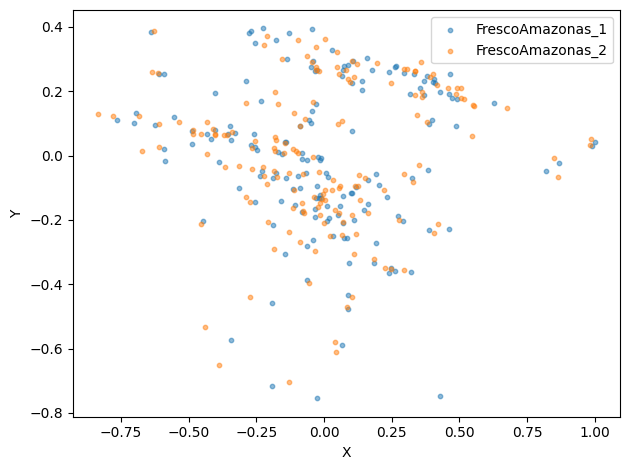

In [23]:
# Node embeddings 2D

if node_embeddings_cat.shape[1] > 2:
	pca = PCA(n_components=2)
	node_embeddings_cat_2d = pca.fit_transform(node_embeddings_cat)
else:
	node_embeddings_cat_2d = node_embeddings_cat.copy()

fig, ax = plt.subplots()

for c in np.unique(labels):
	idx = labels == c
	ax.scatter(
		node_embeddings_cat_2d[idx, 0],
		node_embeddings_cat_2d[idx, 1],
		s=10,
		alpha=0.5,
		label=f"{train_set[c]}"
	)

ax.set_xlabel("X")
ax.set_ylabel("Y")
ax.legend()
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/node_embeddings_{encoder}_{train_set}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

### Similarity analysis (KNN)

In [24]:
train_set

['FrescoAmazonas_1', 'FrescoAmazonas_2']

In [25]:
# Get node ids

dict_node_id = {}

if dataset in ["deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05"]:
	for ts in train_set:
		df_nodes = pd.read_csv("data/{}/input/nodes_{}.csv".format(dataset, ts))
		# idx,id,mz,rt,intensity_mean,intensity_cv

		dict_node_id[ts] = df_nodes["id"].values
else:
	for ts in train_set:
		dict_node_id[ts] = np.arange(len(dict_node_embeddings[ts]))
dict_node_id

{'FrescoAmazonas_1': array([  0,   1,   2,   3,   4,   6,   7,   8,   9,  10,  11,  13,  14,
         15,  16,  17,  19,  20,  21,  22,  23,  24,  25,  26,  27,  28,
         29,  30,  31,  32,  33,  34,  35,  36,  39,  40,  41,  42,  43,
         44,  45,  46,  48,  49,  50,  51,  52,  53,  54,  55,  56,  57,
         58,  59,  60,  61,  62,  65,  67,  68,  69,  70,  71,  72,  74,
         76,  79,  80,  82,  85,  86,  87,  88,  89,  90,  91,  92,  93,
         94,  95,  96,  97,  98,  99, 100, 102, 103, 104, 105, 106, 107,
        108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 122,
        123, 124, 125, 126, 127, 128, 129, 131, 132, 133, 134, 135, 137,
        138, 139, 140, 141, 142, 143, 144, 145, 146, 147, 148, 149, 150,
        151, 152, 153, 154, 155, 156, 157, 158, 159, 160, 161,   5,  63,
         64,  81, 130,  73,  84, 101, 112,  12,  18,  37,  47,  66,  75,
         83,  38,  77,  78, 115, 136]),
 'FrescoAmazonas_2': array([  0,   2,   3,   4,   5,   6,   7,  

In [26]:
# Calculate distance matrix (KNN)

k = 1 # Change
knn = NearestNeighbors(n_neighbors=k, metric="euclidean")

first_ts = train_set[0]
x = dict_node_embeddings[first_ts]

df_node_alignment = pd.DataFrame()
df_node_alignment[first_ts] = dict_node_id[first_ts]

for ts in train_set[1:]:
	y = dict_node_embeddings[ts]
	
	knn.fit(y)
	distances, indices = knn.kneighbors(x)
	indices = indices.squeeze() # (N,)

	df_node_alignment[ts] = dict_node_id[ts][indices]
	df_node_alignment[f"distances"] = distances
df_node_alignment

,FrescoAmazonas_1,FrescoAmazonas_2,distances
0,0,41,0.116608
1,1,9,0.076496
2,2,2,0.045699
3,3,3,0.027905
4,4,18,0.104091
...,...,...,...
157,38,44,0.105459
158,77,77,0.029881
159,78,108,0.116486
160,115,108,0.025744


In [27]:
df_node_alignment.describe()

,FrescoAmazonas_1,FrescoAmazonas_2,distances
count,162.000000,162.000000,162.000000
mean,80.500000,80.802469,0.060361
std,46.909487,45.923896,0.049167
min,0.000000,2.000000,0.010622
25%,40.250000,40.250000,0.028726
50%,80.500000,78.000000,0.046782
75%,120.750000,118.750000,0.080496
max,161.000000,161.000000,0.455447


In [28]:
avg_distances = df_node_alignment["distances"].mean()
avg_distances

0.0603608836442876

In [29]:
""" df_node_alignment = df_node_alignment[df_node_alignment["distances"] <= avg_distances].iloc[:, :-1]
df_node_alignment """

df_node_alignment = df_node_alignment.iloc[:, :-1]

In [30]:
# Find node alignment 2 by 2

col1, col2 = train_set[:2] # Change
print(col1, col2)

df_node_alignment_filter = df_node_alignment[df_node_alignment.apply(lambda row: row[col1] == row[col2], axis=1)]
df_node_alignment_filter

FrescoAmazonas_1 FrescoAmazonas_2


,FrescoAmazonas_1,FrescoAmazonas_2
2,2,2
3,3,3
13,15,15
14,16,16
15,17,17
...,...,...
149,112,112
151,18,18
152,37,37
153,47,47


In [31]:
# Find node alignment for all datasets

df_node_alignment_filter = df_node_alignment[df_node_alignment.nunique(axis=1) == 1]
print(len(df_node_alignment_filter))
df_node_alignment_filter

93


,FrescoAmazonas_1,FrescoAmazonas_2
2,2,2
3,3,3
13,15,15
14,16,16
15,17,17
...,...,...
149,112,112
151,18,18
152,37,37
153,47,47


In [32]:
# Comparison (with test_pairs)

if dataset not in ["deybis_filter_september_05", "deybis_05", "vanessa_05", "mentos_05"]:
	print(len(test_pairs))
	# print(test_pairs)
	# print(df_node_alignment.values)
	mask = np.array([tuple(row) in map(tuple, test_pairs) for row in df_node_alignment.values])
	df_node_alignment["mask"] = mask
	print(df_node_alignment[df_node_alignment["mask"] == True])

### Filter MS data

In [33]:
common_node_id = df_node_alignment_filter.iloc[:, 0].values
common_node_id

array([  2,   3,  15,  16,  17,  19,  20,  25,  26,  27,  29,  30,  31,
        32,  33,  34,  35,  36,  39,  40,  44,  45,  46,  48,  50,  51,
        52,  55,  56,  59,  60,  61,  62,  65,  67,  69,  72,  74,  85,
        88,  91,  92,  94,  95,  96,  97,  98, 100, 103, 104, 105, 107,
       109, 113, 116, 118, 119, 120, 121, 123, 124, 125, 126, 127, 129,
       135, 138, 139, 140, 141, 142, 143, 144, 146, 150, 151, 152, 153,
       154, 155, 156, 157, 159, 160, 161,  63,  81,  84, 112,  18,  37,
        47,  77])

In [34]:
# Read raw data

df_join_raw = pd.read_csv("data/{}/input/raw.csv".format(dataset), index_col=0)
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
0,1.754,167.01318,unknown,2.102369e+07,5.191424e+06,2.297892e+06,3.229474e+07,3.107148e+07,5.171922e+06,2.880494e+07,...,1.720800e+06,5.260539e+06,5.884508e+06,2.032107e+06,4.365939e+06,5.541052e+06,1.244700e+06,3.412579e+07,1.300488e+07,7.499824e+06
1,2.120,152.05702,unknown,2.420068e+06,2.307995e+06,5.114995e+06,5.664406e+05,6.075747e+05,9.785619e+05,6.388311e+05,...,9.573049e+05,1.771467e+06,1.866798e+06,3.887925e+06,1.728809e+06,1.752814e+06,3.559701e+06,7.633949e+05,7.586965e+05,1.544267e+06
2,2.125,257.96816,unknown,9.001219e+06,9.873734e+06,7.146516e+05,1.099685e+07,1.102387e+07,7.044592e+05,1.529399e+07,...,1.038209e+06,1.003099e+07,1.058112e+07,5.771471e+05,1.331955e+07,1.382660e+07,8.397252e+05,9.151868e+06,9.999602e+06,1.219800e+06
3,2.128,207.98572,unknown,1.938034e+07,2.008965e+07,2.191925e+06,2.779337e+07,2.368245e+07,2.417852e+06,2.770186e+07,...,1.879193e+06,1.891332e+07,1.875001e+07,1.680360e+06,2.098740e+07,2.042521e+07,1.437406e+06,2.369094e+07,2.617182e+07,3.319935e+06
4,2.133,217.96001,unknown,9.418357e+06,9.172249e+06,1.434368e+07,1.256749e+07,1.200879e+07,1.610727e+07,1.448343e+07,...,2.158761e+07,9.322098e+06,9.037713e+06,1.298658e+07,1.090200e+07,1.103374e+07,1.543508e+07,1.196644e+07,1.212436e+07,2.462687e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20.487,501.26053,unknown,5.709668e+06,5.691558e+06,4.908186e+06,8.214671e+06,8.060828e+06,7.154128e+06,6.951144e+06,...,6.457166e+06,5.127135e+06,4.955646e+06,4.566583e+06,4.639459e+06,4.602868e+06,3.850485e+06,8.845150e+06,9.611742e+06,8.629254e+06
158,22.679,520.34109,unknown,1.034447e+07,1.153674e+07,3.173041e+07,1.338164e+06,1.248430e+06,4.271653e+06,3.965387e+05,...,3.035556e+07,1.844937e+07,1.903460e+07,5.936571e+07,1.951251e+07,1.939011e+07,5.120970e+07,5.499485e+05,5.482506e+05,1.901125e+06
159,23.180,200.20136,unknown,7.190209e+06,6.419463e+06,1.939271e+07,9.675436e+06,9.527342e+06,3.067538e+07,9.600671e+06,...,2.646694e+07,5.868539e+06,6.047440e+06,1.754588e+07,5.603531e+06,6.290763e+06,1.664977e+07,1.037119e+07,1.042731e+07,3.352375e+07
160,24.234,496.34082,unknown,2.836296e+07,2.610888e+07,5.500906e+07,3.428636e+07,3.042322e+07,6.613276e+07,2.900143e+07,...,5.965081e+07,2.516866e+07,2.516913e+07,5.005681e+07,2.480254e+07,2.506261e+07,4.261884e+07,3.936421e+07,3.870481e+07,7.023319e+07


In [35]:
print(len(common_node_id), len(df_join_raw))

93 162


In [36]:
df_join_raw_filter = df_join_raw.loc[common_node_id].iloc[:, [0, 1, 2]]
# df_join_raw_filter.to_csv(f"data/{dataset}/output/node_alignment_{encoder}_{dataset}_{train_set}.csv", sep=";", decimal=",", index_label="Id")
df_join_raw_filter

,Average Rt,Average Mz,Metabolite name
2,2.125,257.96816,unknown
3,2.128,207.98572,unknown
15,2.359,180.10227,unknown
16,2.409,153.99819,unknown
17,2.411,182.02951,unknown
...,...,...,...
112,11.596,419.18203,unknown
18,2.560,182.02950,unknown
37,3.513,166.08670,unknown
47,5.402,291.08683,unknown


In [37]:
# Comparison (sta vs Vanessa)

list_node_id_sta = [39, 52, 70, 79, 94, 91, 90, 116, 123, 126, 127, 159, 157, 160, 175, 188, 190, 189, 173, 205, 202, 211, 212]

match = set(list_node_id_sta) & set(common_node_id)
print(train_set)
print(f"Alignment: {len(common_node_id)} / {len(df_join_raw)}")
print(f"Match comp: {len(match)}/{len(list_node_id_sta)}")
print(match)

['FrescoAmazonas_1', 'FrescoAmazonas_2']
Alignment: 93 / 162
Match comp: 11/23
{160, 39, 123, 52, 116, 126, 91, 127, 157, 94, 159}


In [38]:
df_join_raw.loc[list(match)].iloc[:, :3]

,Average Rt,Average Mz,Metabolite name
160,24.234,496.34082,unknown
39,3.515,120.08126,unknown
123,11.971,561.17636,unknown
52,5.924,328.22375,unknown
116,11.730,549.24528,unknown
126,11.975,287.10311,unknown
91,9.823,473.13284,unknown
127,11.992,460.21618,unknown
157,20.487,501.26053,unknown
94,9.913,658.26166,unknown


### Clustering analysis

In [39]:
df_join_raw

,Average Rt,Average Mz,Metabolite name,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
0,1.754,167.01318,unknown,2.102369e+07,5.191424e+06,2.297892e+06,3.229474e+07,3.107148e+07,5.171922e+06,2.880494e+07,...,1.720800e+06,5.260539e+06,5.884508e+06,2.032107e+06,4.365939e+06,5.541052e+06,1.244700e+06,3.412579e+07,1.300488e+07,7.499824e+06
1,2.120,152.05702,unknown,2.420068e+06,2.307995e+06,5.114995e+06,5.664406e+05,6.075747e+05,9.785619e+05,6.388311e+05,...,9.573049e+05,1.771467e+06,1.866798e+06,3.887925e+06,1.728809e+06,1.752814e+06,3.559701e+06,7.633949e+05,7.586965e+05,1.544267e+06
2,2.125,257.96816,unknown,9.001219e+06,9.873734e+06,7.146516e+05,1.099685e+07,1.102387e+07,7.044592e+05,1.529399e+07,...,1.038209e+06,1.003099e+07,1.058112e+07,5.771471e+05,1.331955e+07,1.382660e+07,8.397252e+05,9.151868e+06,9.999602e+06,1.219800e+06
3,2.128,207.98572,unknown,1.938034e+07,2.008965e+07,2.191925e+06,2.779337e+07,2.368245e+07,2.417852e+06,2.770186e+07,...,1.879193e+06,1.891332e+07,1.875001e+07,1.680360e+06,2.098740e+07,2.042521e+07,1.437406e+06,2.369094e+07,2.617182e+07,3.319935e+06
4,2.133,217.96001,unknown,9.418357e+06,9.172249e+06,1.434368e+07,1.256749e+07,1.200879e+07,1.610727e+07,1.448343e+07,...,2.158761e+07,9.322098e+06,9.037713e+06,1.298658e+07,1.090200e+07,1.103374e+07,1.543508e+07,1.196644e+07,1.212436e+07,2.462687e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
157,20.487,501.26053,unknown,5.709668e+06,5.691558e+06,4.908186e+06,8.214671e+06,8.060828e+06,7.154128e+06,6.951144e+06,...,6.457166e+06,5.127135e+06,4.955646e+06,4.566583e+06,4.639459e+06,4.602868e+06,3.850485e+06,8.845150e+06,9.611742e+06,8.629254e+06
158,22.679,520.34109,unknown,1.034447e+07,1.153674e+07,3.173041e+07,1.338164e+06,1.248430e+06,4.271653e+06,3.965387e+05,...,3.035556e+07,1.844937e+07,1.903460e+07,5.936571e+07,1.951251e+07,1.939011e+07,5.120970e+07,5.499485e+05,5.482506e+05,1.901125e+06
159,23.180,200.20136,unknown,7.190209e+06,6.419463e+06,1.939271e+07,9.675436e+06,9.527342e+06,3.067538e+07,9.600671e+06,...,2.646694e+07,5.868539e+06,6.047440e+06,1.754588e+07,5.603531e+06,6.290763e+06,1.664977e+07,1.037119e+07,1.042731e+07,3.352375e+07
160,24.234,496.34082,unknown,2.836296e+07,2.610888e+07,5.500906e+07,3.428636e+07,3.042322e+07,6.613276e+07,2.900143e+07,...,5.965081e+07,2.516866e+07,2.516913e+07,5.005681e+07,2.480254e+07,2.506261e+07,4.261884e+07,3.936421e+07,3.870481e+07,7.023319e+07


In [40]:
df_join_raw_signal = df_join_raw.loc[common_node_id].iloc[:, 3:] # Important two last column no only to Mentos 3:-2
df_join_raw_signal

,SecoAmazonas_1.1,SecoAmazonas_1.2,SecoAmazonas_1.3,FrescoSanMartin_1.1,FrescoSanMartin_1.2,FrescoSanMartin_1.3,FrescoSanMartin_2.1,FrescoSanMartin_2.2,FrescoSanMartin_2.3,FrescoCusco_1.1,...,SecoSanMartin_2.3,SecoCusco_1.1,SecoCusco_1.2,SecoCusco_1.3,SecoCusco_2.1,SecoCusco_2.2,SecoCusco_2.3,FrescoAmazonas_2.1,FrescoAmazonas_2.2,FrescoAmazonas_2.3
2,9.001219e+06,9.873734e+06,7.146516e+05,1.099685e+07,1.102387e+07,7.044592e+05,1.529399e+07,1.504451e+07,8.578103e+05,1.698069e+07,...,1.038209e+06,1.003099e+07,1.058112e+07,5.771471e+05,1.331955e+07,1.382660e+07,8.397252e+05,9.151868e+06,9.999602e+06,1.219800e+06
3,1.938034e+07,2.008965e+07,2.191925e+06,2.779337e+07,2.368245e+07,2.417852e+06,2.770186e+07,2.856326e+07,2.172423e+06,2.992950e+07,...,1.879193e+06,1.891332e+07,1.875001e+07,1.680360e+06,2.098740e+07,2.042521e+07,1.437406e+06,2.369094e+07,2.617182e+07,3.319935e+06
15,7.192834e+05,7.550322e+05,1.268768e+06,8.624610e+05,8.004201e+05,2.081688e+06,1.942538e+05,6.746691e+05,1.707270e+06,8.487757e+05,...,1.741357e+06,7.240730e+05,7.522934e+05,1.181816e+06,5.889834e+05,5.689102e+05,1.042015e+06,8.842900e+05,1.087527e+06,2.477408e+06
16,2.879468e+07,3.099976e+07,4.897906e+07,4.584738e+07,4.617611e+07,7.825773e+07,4.545407e+07,4.089207e+07,6.479307e+07,4.478399e+07,...,5.695610e+07,2.829897e+07,2.899276e+07,4.295265e+07,2.941151e+07,2.766474e+07,3.550827e+07,5.255775e+07,4.801114e+07,8.738797e+07
17,1.977290e+07,1.834976e+07,4.691158e+07,2.781082e+07,2.814999e+07,6.801390e+07,2.723531e+07,2.817812e+07,6.446211e+07,2.783895e+07,...,3.136616e+07,1.644852e+07,1.751921e+07,2.216183e+07,1.613057e+07,1.674702e+07,2.190162e+07,2.899868e+07,3.145331e+07,4.615107e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
112,1.049287e+08,9.901347e+07,1.789771e+07,1.410959e+08,1.404979e+08,2.549190e+07,1.324846e+08,1.252668e+08,2.586244e+07,1.332308e+08,...,2.972568e+07,8.821045e+07,8.412190e+07,1.540817e+07,8.303290e+07,8.590362e+07,1.526961e+07,1.531527e+08,1.522716e+08,3.064067e+07
18,1.025633e+07,1.338383e+07,2.069147e+07,1.922827e+07,1.822783e+07,3.231810e+07,1.787181e+07,1.356190e+07,3.075988e+07,1.689679e+07,...,3.408547e+07,1.213554e+07,1.157098e+07,1.871899e+07,1.087331e+07,1.094314e+07,1.483153e+07,1.912046e+07,2.104668e+07,3.359476e+07
37,1.253999e+06,1.441073e+06,5.271651e+07,9.137562e+05,7.917004e+05,1.343622e+07,6.557196e+05,7.676576e+05,1.266291e+07,1.112430e+06,...,1.687432e+07,1.618958e+06,1.721775e+06,7.036313e+07,2.671818e+06,2.876777e+06,3.376854e+07,8.784846e+05,7.630793e+05,1.320947e+07
47,3.386188e+06,3.331911e+06,7.095266e+06,2.201200e+08,2.144403e+08,4.932659e+08,2.154287e+08,2.147171e+08,4.404592e+08,2.143785e+08,...,6.638500e+06,3.952095e+06,4.085255e+06,9.305475e+06,5.555176e+06,5.588347e+06,1.227614e+07,6.598546e+07,6.701335e+07,1.486927e+08


In [41]:
df_join_raw_signal_t = df_join_raw_signal.T
df_join_raw_signal_t

,2,3,15,16,17,19,20,25,26,27,...,160,161,63,81,84,112,18,37,47,77
SecoAmazonas_1.1,9.001219e+06,1.938034e+07,7.192834e+05,28794677.58,19772900.50,6.515615e+07,1.138388e+06,1.760667e+07,2.103618e+05,6.315598e+05,...,28362963.52,2.889893e+07,2.228551e+07,422949.28790,1.571036e+08,1.049287e+08,1.025633e+07,1.253999e+06,3.386188e+06,1.144139e+09
SecoAmazonas_1.2,9.873734e+06,2.008965e+07,7.550322e+05,30999762.53,18349758.37,6.116227e+07,1.024190e+06,1.628310e+07,2.326174e+05,5.736506e+05,...,26108876.20,2.822468e+07,2.115173e+07,382559.67680,1.339136e+08,9.901347e+07,1.338383e+07,1.441073e+06,3.331911e+06,1.159910e+09
SecoAmazonas_1.3,7.146516e+05,2.191925e+06,1.268768e+06,48979060.79,46911583.15,1.115087e+08,1.423514e+05,6.022952e+07,6.176089e+05,3.217070e+05,...,55009056.36,8.887856e+07,6.559894e+05,71331.23918,8.303704e+06,1.789771e+07,2.069147e+07,5.271651e+07,7.095266e+06,4.727884e+07
FrescoSanMartin_1.1,1.099685e+07,2.779337e+07,8.624610e+05,45847375.55,27810818.86,9.074104e+07,8.344111e+06,3.069929e+07,5.011401e+05,5.542806e+04,...,34286358.84,2.956855e+06,3.113441e+07,565591.95340,2.026872e+08,1.410959e+08,1.922827e+07,9.137562e+05,2.201200e+08,1.441182e+09
FrescoSanMartin_1.2,1.102387e+07,2.368245e+07,8.004201e+05,46176110.24,28149989.33,8.690604e+07,8.039500e+06,3.568783e+07,5.718729e+05,5.386143e+04,...,30423224.96,2.469806e+06,2.747322e+07,526223.43340,1.924726e+08,1.404979e+08,1.822783e+07,7.917004e+05,2.144403e+08,1.541211e+09
FrescoSanMartin_1.3,7.044592e+05,2.417852e+06,2.081688e+06,78257734.16,68013902.77,1.572174e+08,3.181915e+05,1.525256e+08,1.828277e+06,5.752042e+04,...,66132756.64,7.627351e+06,1.578237e+06,101591.97710,1.380518e+07,2.549190e+07,3.231810e+07,1.343622e+07,4.932659e+08,1.053864e+08
FrescoSanMartin_2.1,1.529399e+07,2.770186e+07,1.942538e+05,45454071.30,27235309.35,8.398495e+07,9.848330e+06,4.518529e+07,5.984180e+05,5.201684e+04,...,29001432.68,1.002173e+06,2.993570e+07,545248.51550,2.123047e+08,1.324846e+08,1.787181e+07,6.557196e+05,2.154287e+08,1.559254e+09
FrescoSanMartin_2.2,1.504451e+07,2.856326e+07,6.746691e+05,40892070.46,28178121.58,8.692964e+07,9.653056e+06,3.430235e+07,3.858499e+05,5.032868e+04,...,28578099.73,1.012401e+06,2.624386e+07,531649.87730,1.664979e+08,1.252668e+08,1.356190e+07,7.676576e+05,2.147171e+08,1.405809e+09
FrescoSanMartin_2.3,8.578103e+05,2.172423e+06,1.707270e+06,64793067.84,64462109.65,1.332212e+08,4.898660e+05,1.673136e+08,1.532058e+06,5.008219e+04,...,49478713.77,2.947043e+06,1.335277e+06,93479.84103,1.422396e+07,2.586244e+07,3.075988e+07,1.266291e+07,4.404592e+08,8.192495e+07
FrescoCusco_1.1,1.698069e+07,2.992950e+07,8.487757e+05,44783987.20,27838954.84,8.668184e+07,1.095064e+07,3.871150e+07,4.138760e+05,5.306694e+04,...,31186741.74,2.674147e+06,3.062430e+07,540798.73430,1.888537e+08,1.332308e+08,1.689679e+07,1.112430e+06,2.143785e+08,1.599351e+09


In [42]:
scaler = StandardScaler()
X_scaled = scaler.fit_transform(df_join_raw_signal_t.values)
X_scaled

array([[ 0.07852159,  0.27875661, -0.57515556, ..., -0.50113726,
        -0.79695601,  0.397742  ],
       [ 0.22431325,  0.34395557, -0.50899125, ..., -0.49089044,
        -0.79730173,  0.42286571],
       [-1.30611059, -1.30117858,  0.44183793, ...,  2.3176762 ,
        -0.77333089, -1.34958637],
       ...,
       [ 0.10369404,  0.67498174, -0.26975941, ..., -0.52170571,
        -0.39822748,  1.39089233],
       [ 0.24534496,  0.90302099,  0.10639445, ..., -0.52802693,
        -0.39168032,  1.33135047],
       [-1.22170353, -1.19749339,  2.67880334, ...,  0.15371292,
         0.12857941, -1.22987643]])

In [43]:
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_scaled)
X_pca

array([[  2.3480642 ,  -4.04988215],
       [  2.34728958,  -3.67406378],
       [-10.03979817,  -0.90438367],
       [  8.13113662,   1.31077138],
       [  8.47434738,   1.66925435],
       [ -6.8580312 ,   8.3629424 ],
       [  8.12982673,   0.86045767],
       [  6.72555311,   0.38996121],
       [ -7.08550679,   7.84903321],
       [  7.47142392,   1.27902463],
       [  8.06958778,   1.49492986],
       [ -6.2514465 ,   9.24757726],
       [  6.62162473,   0.70434676],
       [  6.43381504,   0.90249491],
       [ -6.62051798,   8.16681862],
       [  8.69115151,   1.57833234],
       [  8.64061956,   1.76590565],
       [ -6.98571862,   7.74929789],
       [ -2.34660418,  -6.58543015],
       [ -2.96261388,  -6.74645065],
       [-11.65359096,  -6.05555008],
       [ -1.53008881,  -5.30373806],
       [ -1.25830212,  -5.29307129],
       [-12.00631133,  -2.92789039],
       [  5.70666066,  -1.04424445],
       [  4.91372135,  -1.341567  ],
       [ -7.34834781,   4.51526693],
 

In [44]:
labels = [item.split("_")[0] for item in df_join_raw_signal_t.index]
labels

['SecoAmazonas',
 'SecoAmazonas',
 'SecoAmazonas',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoSanMartin',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoCusco',
 'FrescoAmazonas',
 'FrescoAmazonas',
 'FrescoAmazonas',
 'SecoAmazonas',
 'SecoAmazonas',
 'SecoAmazonas',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoSanMartin',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'SecoCusco',
 'FrescoAmazonas',
 'FrescoAmazonas',
 'FrescoAmazonas']

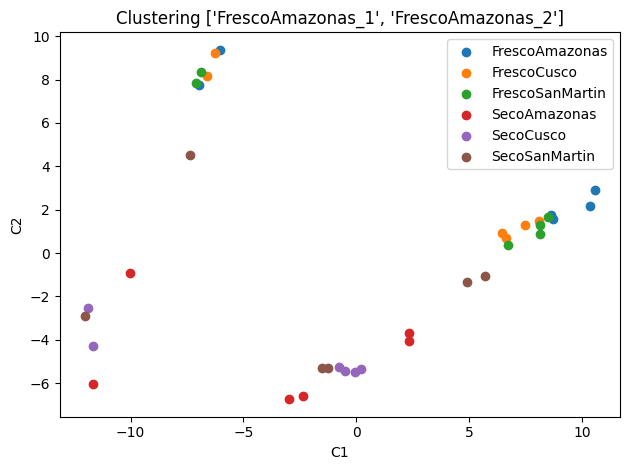

In [45]:
x, y = X_pca[:, 0], X_pca[:, 1]

unique_groups = np.unique(labels)

for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.tight_layout()
# plt.savefig(f"data/{dataset}/output/plot/clustering_{encoder}_{str(train_set)}_{features}.pdf", format="pdf", bbox_inches="tight")
plt.show()

In [46]:
from sklearn.manifold import TSNE

X_tsne = TSNE(n_components=2, learning_rate="auto", init="pca", perplexity=3).fit_transform(X_scaled)

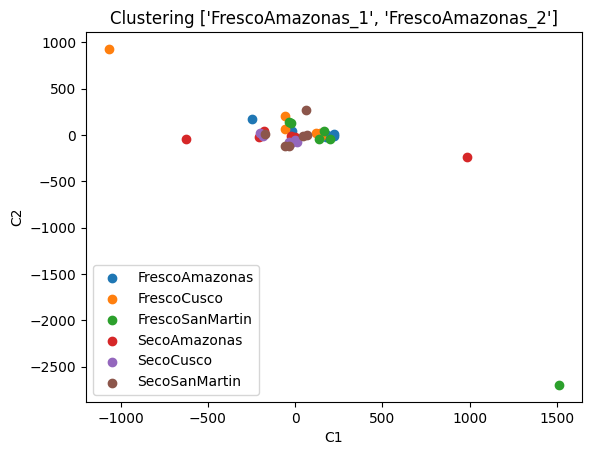

In [47]:
x, y = X_tsne[:, 0], X_tsne[:, 1]

unique_groups = np.unique(labels)

plt.figure()
for group in unique_groups:
	xi = [x[i] for i in range(len(x)) if labels[i] == group]
	yi = [y[i] for i in range(len(y)) if labels[i] == group]
	plt.scatter(xi, yi, label=group)

plt.legend()
plt.xlabel("C1")
plt.ylabel("C2")
plt.title(f"Clustering {train_set}")
plt.show()

In [48]:
# import torch
# print(torch.cuda.memory_summary())